# Julian Lapenna Acoustics Lab

Sept 19, 16:20

Logged on. I don't see a `BareBonesDAQ.m` file... Maybe a python file has replaced it

In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [22]:
from scipy.io import wavfile
samplerate, data = wavfile.read('../data/resonant.wav')
print(data.shape)
print ("Frequency sampling:", samplerate)

(480000, 2)
Frequency sampling: 96000


In [23]:
print(len(data)/samplerate) # time sampled for

5.0


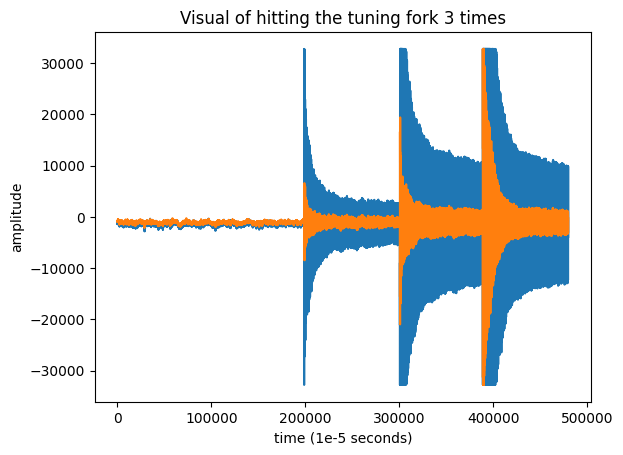

In [24]:
plt.plot(data)
plt.title('Visual of hitting the tuning fork 3 times')
plt.xlabel('time (1e-5 seconds)')
plt.ylabel('amplitude');

In [25]:
print(data[200000]) # looks about right with graph above

[8412  116]


File naming convention (for future):

pXXXX-fXXX-aXX-tXX-X.wav = p\<position\>-f\<frequency\>-a\<amplitude\>-t\<time\>-\<close\far\>.wav

where 
* position = number of steps of the stepper motor and tells me the angle I should be observing
* frequency = 365 Hz the fundamental frequency
* amplitude = the amplitude the motor is set to, for now probably 5
* time = how long the motor goes for, for now probably 5 seconds
* c/f = for movable mic, is it close (~1-3cm) or far (~20-50cm) away

In [26]:
data1 = []

for d in data:
    data1.append(d[0])

print(len(data1))

480000


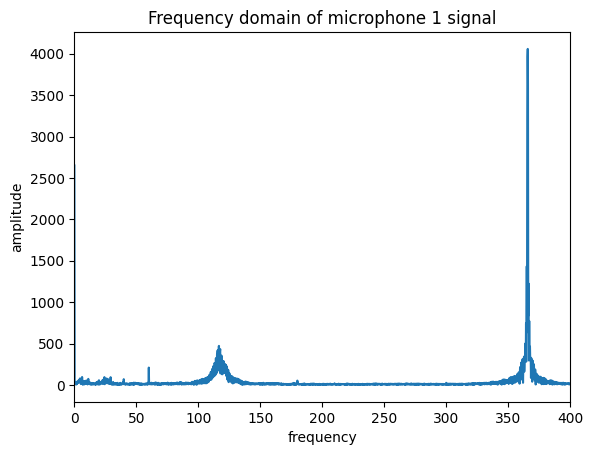

In [27]:
# finding the resonant frequency
from scipy.fft import fft, fftfreq
N = 480000 # sample points
T = 1 / samplerate

yf = fft(data1)
xf = fftfreq(N, T)[:N//2]

# why I divide by N: 
# https://electronics.stackexchange.com/questions/25900/
# scaling-fft-output-by-number-of-points-in-fft
# summary: there are N samples of each component of the signal that scale with N
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Frequency domain of microphone 1 signal')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,400])
plt.show()

In [28]:
print("resonant frequency:", xf[np.argmax(yf)], "Hz")

resonant frequency: 365.20000000000005 Hz


So the resonant frequency of the tuning fork is 365 Hz! Great :)

Sept 25, 15:25

Plan, get data from the close field, again in a 90deg sweep since the tuning fork is symmetric, then analyse the data later.

Issue that came up: The stepper motor that is used to position the mic at different positions was broken, so I took a protractor and switched to measuring the angle by hand. This will be a source of error, but I am hoping the data will still show the appropriate trends.

In [29]:
def show_audio_file(filename):
    samplerate, data = wavfile.read(filename)
    print(data.shape)
    print ("Frequency sampling:", samplerate)
    plt.plot(data)

def show_freqs_audio_file(filename):
    samplerate, data = wavfile.read(filename)

    data1 = []

    for d in data:
        data1.append(d[1]) # getting mic 2, the one that moves

    N = len(data1) # sample points
    T = len(data) / samplerate

    yf = fft(data1)
    xf = fftfreq(N, T)[:N//2]

    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title('frequency domain of signal')
    plt.xlabel('frequency')
    plt.ylabel('amplitude')
    plt.xlim([0,600])
    plt.show()



(192000, 2)
192000
-1124
-1103
-1098
-1083
-1080
-1076
-1070
-1065
-1069
-1078
192000 2.0


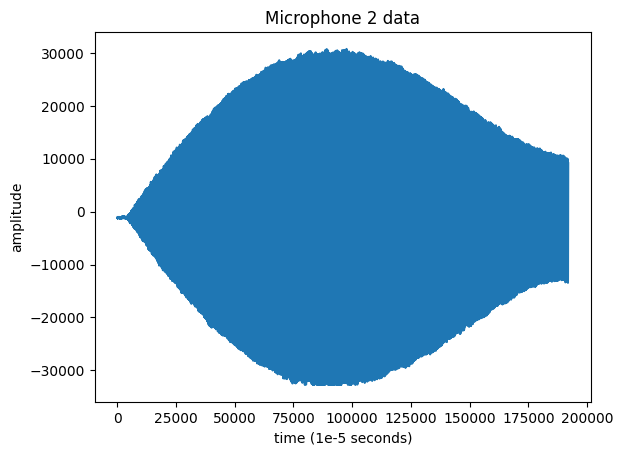

In [30]:
filename = '../data/deg05-f365-a05-t02-c.wav'
# show_audio_file(filename)
# show_freqs_audio_file(filename)

samplerate, data = wavfile.read(filename)

data1 = []

for d in data:
    data1.append(d[1]) # getting mic 2, the one that moves

plt.plot(data1)
plt.title('Microphone 2 data')
plt.ylabel('amplitude')
plt.xlabel('time (1e-5 seconds)')
print(data.shape)
print(len(data1))

for i in range(10):
    print(data1[i])

N = len(data1) # sample points
T = len(data) / samplerate

print(N,T)

# yf = fft(data1)
# xf = fftfreq(N, T)[:N//2]

# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.title('frequency domain of signal')
# plt.xlabel('frequency')
# plt.ylabel('amplitude')
# plt.xlim([0,600])
# plt.show()

Sept 26, 15:35

Hold on, I don't even need to take the fourier transform, I'm looking at amplitude. So maybe let's look at some of the graphs of the far and close field at the expect minimums.

Close field 45deg, far field 90deg. Additionally, r for close = 1cm, while r for far = 20cm.

(192000, 2)
Frequency sampling: 96000


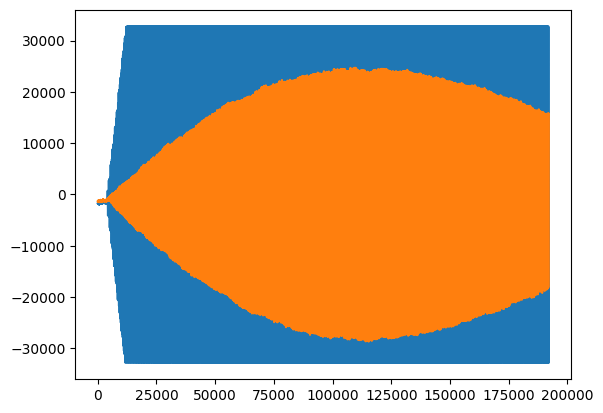

In [31]:
filename = '../data/deg45-f365-a05-t02-c.wav'
show_audio_file(filename)

32767
(192000, 2)
Frequency sampling: 96000


Text(0.5, 0, 'time (1e-5 seconds)')

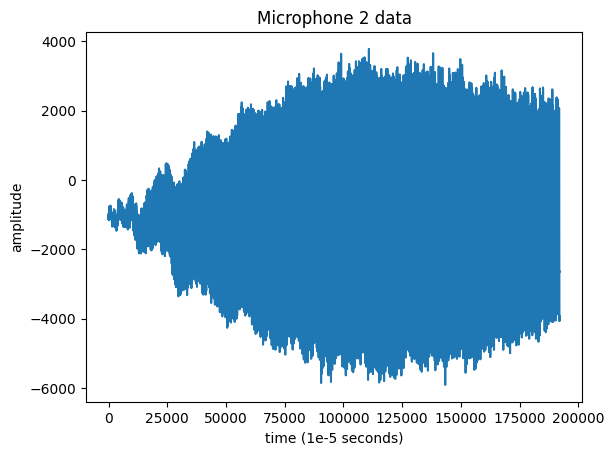

In [32]:
print(np.max(data))

filename = '../data/deg70-f365-a05-t02-c.wav'
samplerate, data = wavfile.read(filename)
print(data.shape)
print ("Frequency sampling:", samplerate)

plt.plot([subdata[1] for subdata in data])
plt.title('Microphone 2 data')
plt.ylabel('amplitude')
plt.xlabel('time (1e-5 seconds)')

# plt.ylim([-4e4, 4e4])

Ahhhh, so after increasing the bounds, the top and bottom are chopped, likely the mic is saturated, I will have to take data at a lower amplitude I think.

How about at another 5deg increment? How about at a maximum?

Additionally mic 1 appears to be closer to the tuning fork.

(288000, 2)
Frequency sampling: 96000
avg val: -1074.4259965277777


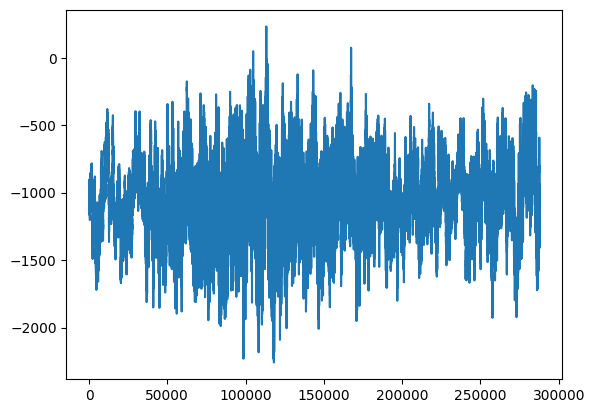

In [33]:
filename = '../data/p800-f365-a05-t03-f.wav'
samplerate, data = wavfile.read(filename)

print(data.shape)
print ("Frequency sampling:", samplerate)

plt.plot(np.take(data, 1, axis=1))
print('avg val:', np.average(np.take(data, 1, axis=1)))

Maybe there is a reason to look at the frequency domain, to see the amplitude of a given frequency...

## Plan

- One microphone was saturated, so take data from the other (that also makes the scale readable)
- There is a linear relationship between air pressure and intensity recorded by the microphone
- I think that a Fourier transform will let me look at how loud the resonant frequency was in a given recording
    - I want the resonant frequency amplitude because this is the frequency I am interested in!
- Test this for a few different values, then make a first attempt at a radial plot (I think that's the correct name...) like the one from the paper by Russel:

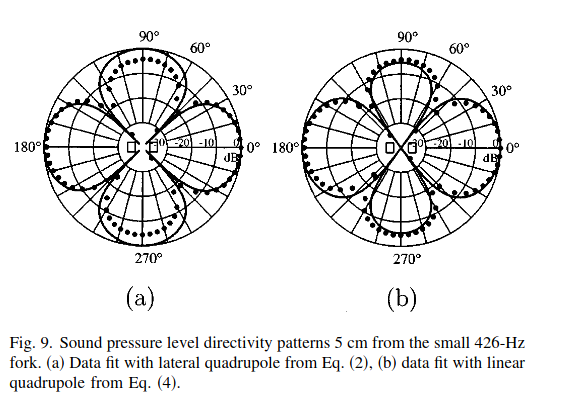

288000 1.0416666666666666e-05


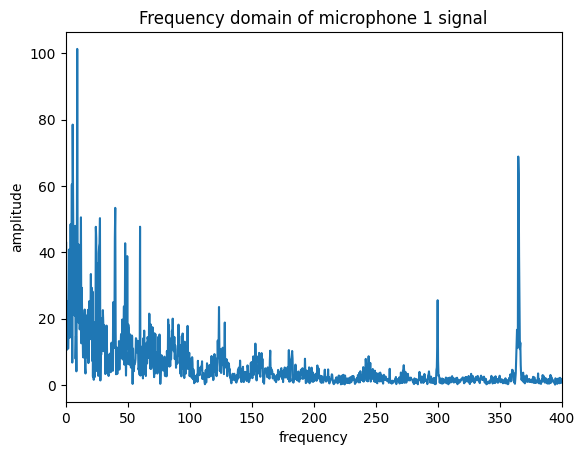

In [34]:
fdata = np.take(data, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,400])
plt.show()


In [35]:
max_index = np.argmax(yf)
print('max_index:', max_index)
print('frequency:', xf[max_index])
print('amp. val.:', yf[max_index]/N*2)

max_index: 28
frequency: 9.333333333333332
amp. val.: 101.33536426834647


Okay, I obviously know that it should be the resonant frequency, but it seems some dc offset is making it look like a dc frequency 0 is the main value. I guess I can try searching at greater than 10Hz (or rather 10 indicies).

EDIT: This was now fixed after I went and subtracted the average to get rid of the DC offset at the first step. I originally didn't do that, and thought of it afterwards, and just changed the code above.

In [36]:
max_index = np.argmax(yf[10:]) + 10
print('max_index:', max_index)
print('frequency:', xf[max_index])
print('amp. val.:', yf[max_index]/N*2)

max_index: 28
frequency: 9.333333333333332
amp. val.: 101.33536426834647


I think at this point I see a clear peak at the resonant frequency and it is probably time to build the data for the radial plot.

Something like

```py
radial_data = (angle, amplitude value)
```

some of the data I took with a protractor and measured the angle by hand (definitely some error there), other data I moved the stepper in increments of 80 which is approximately 5 degrees:

5730 steps / 360 deg = 15.91 steps/deg 

15.91 steps/deg * 5 deg = 79.58 steps $\approx$ 80 steps for 5 degrees

In [37]:
radial_data_close_field = []
radial_data_far_field = []

In [38]:
# function to get the amplitude value
# should take in a filename
def get_amplitude(filename):
    samplerate, data = wavfile.read(filename)

    fdata = np.take(data, 1, axis=1) # mic that is not saturated
    fdata = fdata - np.average(fdata) # to get rid of the dc offset

    N = len(fdata) # sample points
    T = 1 / samplerate

    yf = np.abs(fft(fdata)[0:N//2])
    xf = fftfreq(N, T)[:N//2]

    max_index = np.argmax(yf)
    
    # we should be looking at 365 Hz
    if not (xf[max_index] > 360):
        print(filename, xf[max_index])    
    if not (xf[max_index] < 370):
        print(filename, xf[max_index])    

    return yf[max_index]/N*2

In [39]:
import os
TOTAL_MOTOR_STEPS = 5730

for filename in os.listdir('../data'):
    if filename.endswith('c.wav'): # close field
        amp = get_amplitude('../data/' + filename)

        if filename.startswith('deg'):
            degree = int(filename.split('-')[0][3:])  # Skip 'deg' and get the number
        
        if filename.startswith('p'):
            degree = int(int(filename.split('-')[0][1:])/TOTAL_MOTOR_STEPS*360)

        file_data = (amp, degree)
        radial_data_close_field.append(file_data)
    
    elif filename.endswith('f.wav'): # far field
        amp = get_amplitude('../data/' + filename)
        
        if filename.startswith('deg'):
            # Skip 'deg' and get the number
            degree = int(filename.split('-')[0][3:])  

        if filename.startswith('p'):
            degree = int(int(filename.split('-')[0][1:])/TOTAL_MOTOR_STEPS*360)

        file_data = (amp, degree)
        radial_data_far_field.append(file_data)

../data/p800-f365-a05-t03-f.wav 9.333333333333332
../data/p480-f365-a05-t02-f.wav 548.0
../data/p1040-f365-a05-t03-f.wav 4.666666666666666
../data/p00-f365-a05-t05-f.wav 8.8
../data/p1440-f365-a05-t03-f.wav 730.0
../data/p1120-f365-a05-t03-f.wav 8.666666666666666
../data/p1280-f365-a05-t03-f.wav 730.0
../data/p240-f365-a05-t02-f.wav 730.5
../data/p00-f366-a05-t05-f.wav 0.2
../data/p000-f370-a05-t05-c.wav 370.0
../data/p960-f365-a05-t03-f.wav 25.0
../data/p1200-f365-a05-t03-f.wav 6.0
../data/p1360-f365-a05-t03-f.wav 730.0
../data/p560-f365-a05-t03-f.wav 547.6666666666666
../data/p000-f380-a05-t05-c.wav 380.0
../data/p400-f365-a05-t02-f.wav 548.0
../data/p80-f365-a05-t02-f.wav 28.0


Okay, there's some issues to be investigated, possibly data to be retaken, but for now we can plot!

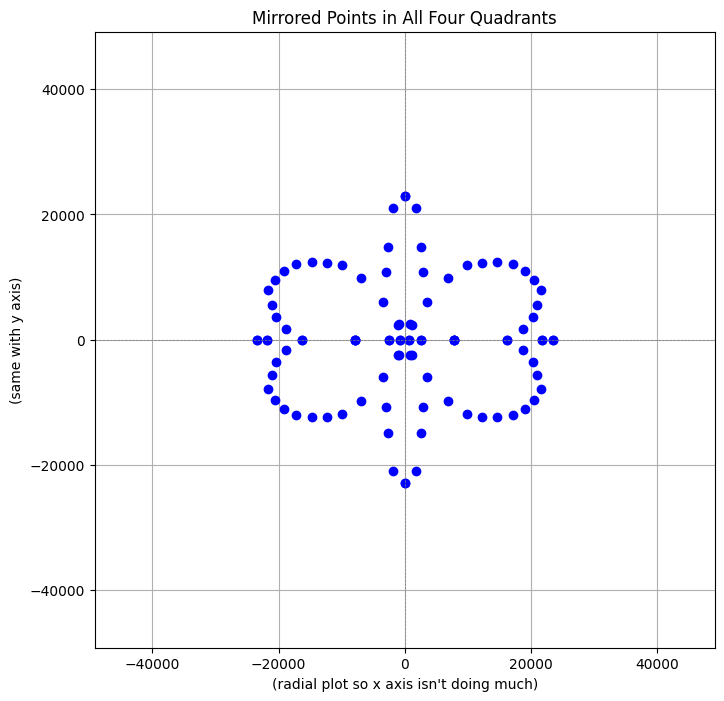

In [40]:
x_values = []
y_values = []

for magnitude, angle in radial_data_close_field:
    # Convert angle to radians
    angle_rad = np.radians(angle)
    
    # Calculate x and y coordinates
    x = magnitude * np.cos(angle_rad)
    y = magnitude * np.sin(angle_rad)
    
    # Append the original and mirrored coordinates
    x_values.extend([x, -x, -x, x])
    y_values.extend([y, y, -y, -y])

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x_values, y_values, 'bo')  # 'bo' means blue color, circle markers
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(0, color='gray', lw=0.5, ls='--')
plt.xlim(-max(magnitude for magnitude, angle in data) 
         * 1.5, max(magnitude for magnitude, angle in data) * 1.5)
plt.ylim(-max(magnitude for magnitude, angle in data) 
         * 1.5, max(magnitude for magnitude, angle in data) * 1.5)
plt.title('Mirrored Points in All Four Quadrants')
plt.xlabel("(radial plot so x axis isn't doing much)")
plt.ylabel('(same with y axis)')
plt.grid()


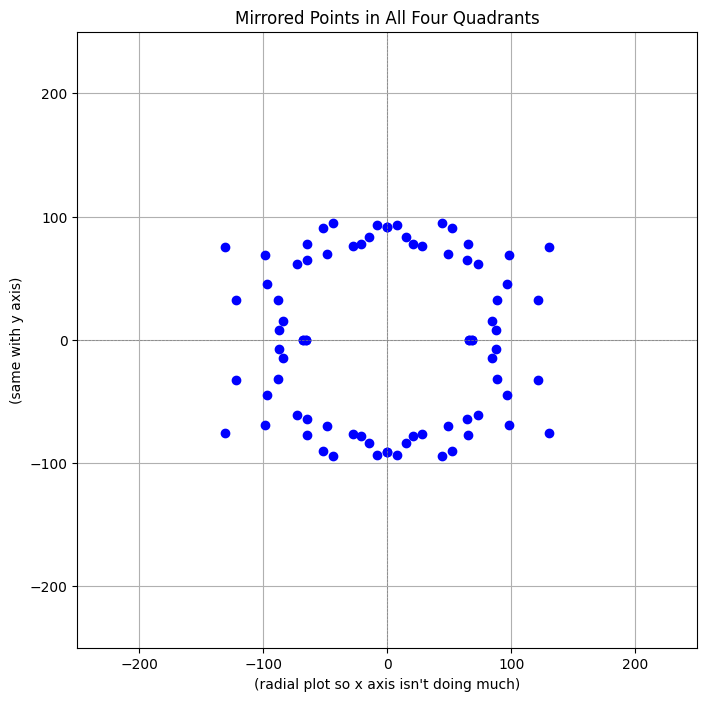

In [41]:
x_values = []
y_values = []

for magnitude, angle in radial_data_far_field:
    # Convert angle to radians
    angle_rad = np.radians(angle)
    
    # Calculate x and y coordinates
    x = magnitude * np.cos(angle_rad)
    y = magnitude * np.sin(angle_rad)
    
    # Append the original and mirrored coordinates
    x_values.extend([x, -x, -x, x])
    y_values.extend([y, y, -y, -y])

# Create the plot
plt.figure(figsize=(8, 8))
plt.plot(x_values, y_values, 'bo')  # 'bo' means blue color, circle markers
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(0, color='gray', lw=0.5, ls='--')
plt.xlim(-250, 250)
plt.ylim(-250, 250)
plt.title('Mirrored Points in All Four Quadrants')
plt.xlabel("(radial plot so x axis isn't doing much)")
plt.ylabel('(same with y axis)')
plt.grid()


# Oct 2, 14:55

So I'm not quite sure these turned out too well. There is definitely lots of error that I can talk about, but for now I am going to get a second form of data to attempt a second plot that might be better.

### Plan:
1. Record data while sweeping around 180degrees for a single plot
2. Compare that data
3. There are known issues with motor 1, if it's having trouble, do everything again but on motor 2


After testing the stepper and it looked clean, I will attempt on motor 1!

With a timer it takes ~ 1 min so I will record for 70 seconds and try to get some buffer time on either side.

Great, now save so I get my data, then try again in far field!

(6720000, 2)
Frequency sampling: 96000


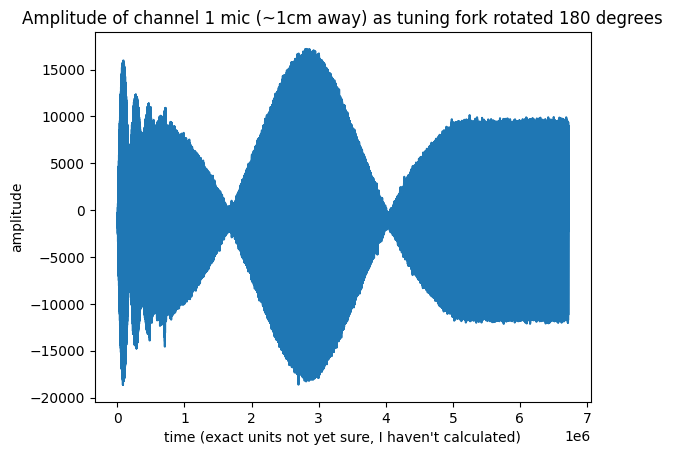

In [54]:
# not really sure what the data should look like, but let's see
filename = '../data/180sweep-m1.wav'
samplerate_1_sweep, data_1_sweep = wavfile.read(filename)

print(data_1_sweep.shape)
print ("Frequency sampling:", samplerate_1_sweep)

plt.title("Amplitude of channel 1 mic (~1cm away) as tuning fork rotated 180 degrees")
plt.xlabel("time (exact units not yet sure, I haven't calculated)")
plt.ylabel('amplitude')
plt.plot(np.take(data_1_sweep, 1, axis=1))

Hey! This actually sort of lines up with what I would want! The y-axis is the amplitude and x-axis is time, and all the while it is rotating at a constant angular velocity which I could figure out with some math. 

This means when it rotated to ~1.8 on the graph, it reached a minima where the sound was very quiet and a there are maxima on either end and a larger one in the middle! This is exactly what I was expecting!!! I'm kinda shocked even though I've been studying this stuff for years lmao

Now for the far field

(5760000, 2)
Frequency sampling: 96000


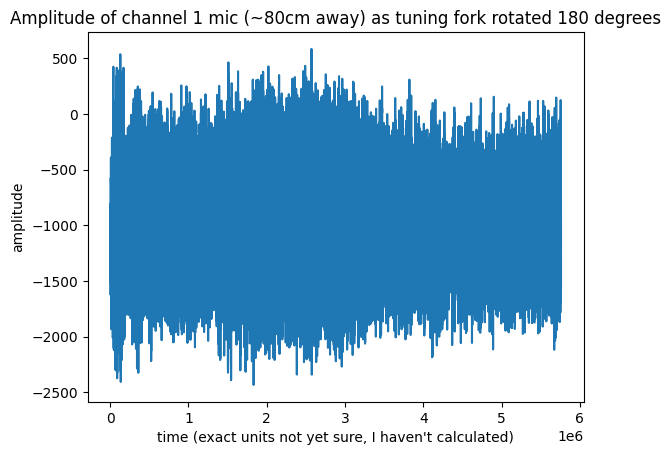

In [43]:
filename = '../data/180sweep-m1-far.wav'
samplerate_80_sweep, data_80_sweep = wavfile.read(filename)

print(data_80_sweep.shape)
print ("Frequency sampling:", samplerate_80_sweep)

plt.title("Amplitude of channel 1 mic (~80cm away) as tuning fork rotated 180 degrees")
plt.xlabel("time (exact units not yet sure, I haven't calculated)")
plt.ylabel('amplitude')
plt.plot(np.take(data_80_sweep, 1, axis=1))

Hmmm okay this doesn't look nearly as good, but there's probably lots of noise... maybe I could take one more sample ~ 30cm away, and I can use that for a stronger signal and then try to denoise this using some filters.

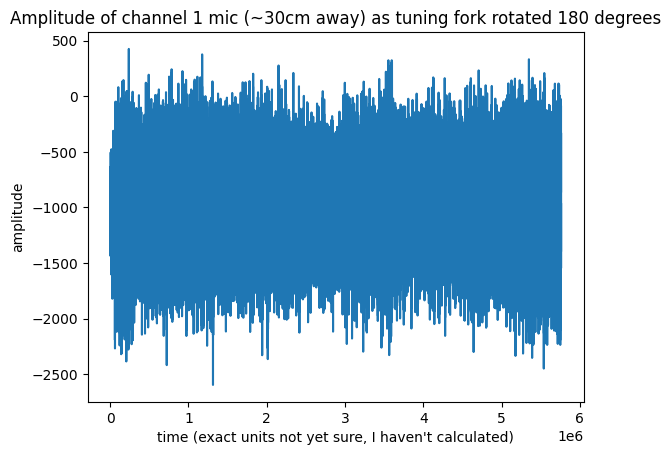

In [44]:
filename = '../data/180sweep-m1-far30.wav'
samplerate_30_sweep, data_30_sweep = wavfile.read(filename)

plt.title("Amplitude of channel 1 mic (~30cm away) "+
          "as tuning fork rotated 180 degrees")
plt.xlabel("time (exact units not yet sure, I haven't calculated)")
plt.ylabel('amplitude')
plt.plot(np.take(data_30_sweep, 1, axis=1))

Okay, well more than enough to work with, but I'll have to do some processing I guess.

Let's check the frequency domain of each of these to make sure they're still all reading the resonant frequency and the main source of sound.

6720000 1.0416666666666666e-05


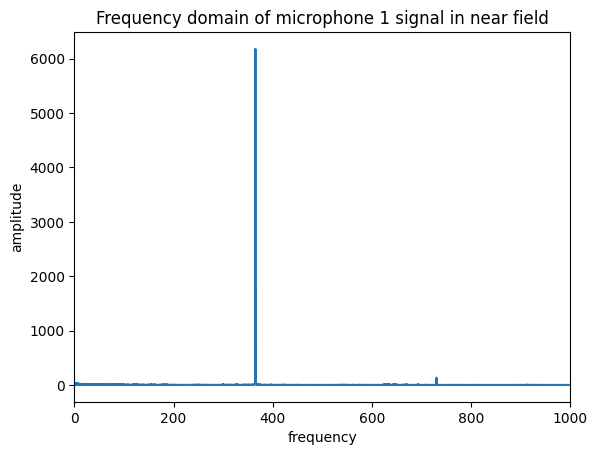

In [45]:
fdata = np.take(data_1_sweep, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate_1_sweep

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal in near field')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,1000])
plt.show()

Okay, yeah awesome! Tuning fork 1 is definitely a lot clearer than tuning fork 2 when I listen so I am glad it shows in the data too

5760000 1.0416666666666666e-05


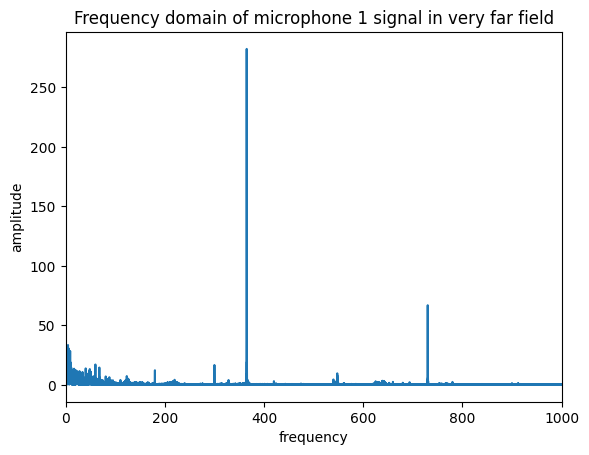

In [122]:
fdata = np.take(data_80_sweep, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate_80_sweep

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal in very far field')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,1000])
plt.show()

Nice, some harmonics it looks like and lots of low frequency noise that I can filter out!

5760000 1.0416666666666666e-05


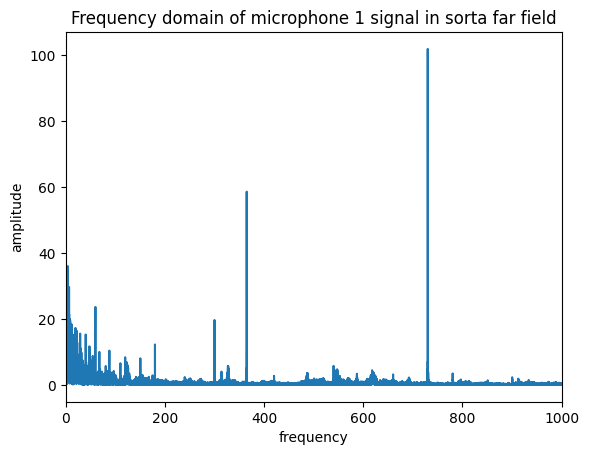

In [47]:
fdata = np.take(data_30_sweep, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate_30_sweep

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal in sorta far field')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,1000])
plt.show()

Hmmmm, that's weird, I got MORE of the harmonic than the fundamental frequency... I will have to think about why that is and ask about this in the lab tomorrow, because I didn't expect this at all.

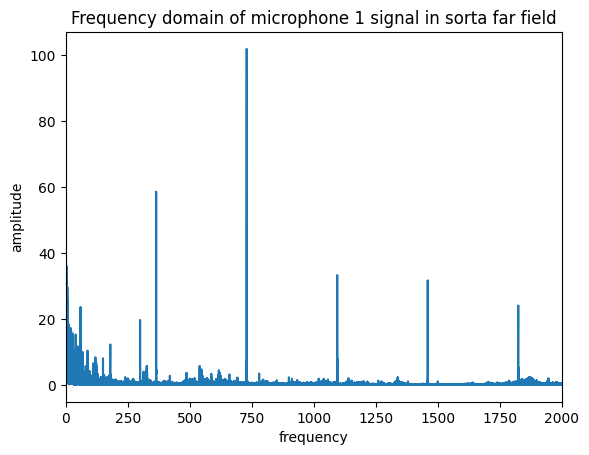

In [48]:
plt.plot(xf, 2.0/N * yf)
plt.title('Frequency domain of microphone 1 signal in sorta far field')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,2000])
plt.show()

Looking at more frequencies, it looks like all the harmonics are quite strong here.

## Radial plot of near field

For now, I will be attempting to get a radial plot using this new measurement technique on the near field data!

In [70]:
# first let's find our data range

data_1_s = np.take(data_1_sweep, 1, axis=1)

d1s_rotation = np.zeros_like(data_1_s) # default to all 0

# getting my range
d1s_rotation[650000:5150000] = data_1_s[650000:5150000]

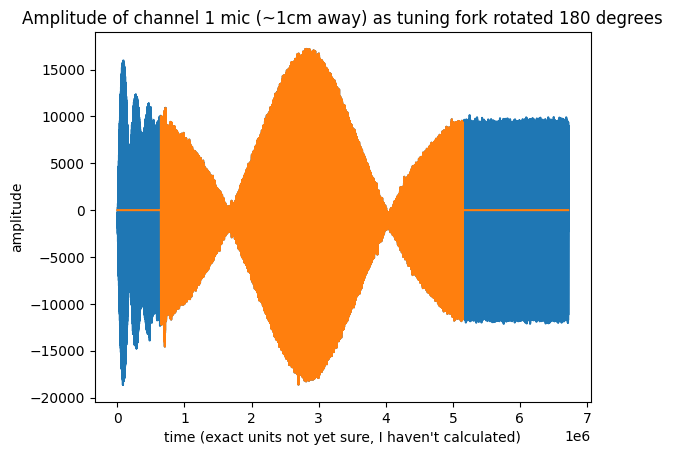

In [71]:
plt.title("Amplitude of channel 1 mic (~1cm away) as tuning fork rotated 180 degrees")
plt.xlabel("time (exact units not yet sure, I haven't calculated)")
plt.ylabel('amplitude')
plt.plot(data_1_s)

plt.plot(d1s_rotation)
plt.show()

Okay, that's a bit hacky, but the orange section looks like when I started rotating the rod, and stopped, so I will go with that.

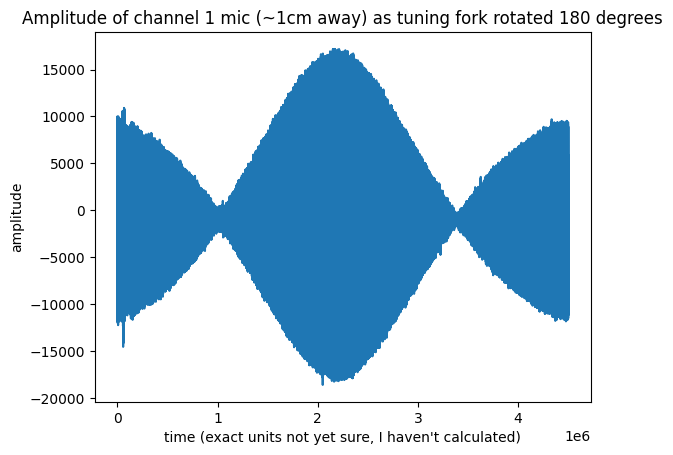

In [72]:
d1s_rotation = d1s_rotation[d1s_rotation != 0]
plt.title("Amplitude of channel 1 mic (~1cm away) as tuning fork rotated 180 degrees")
plt.xlabel("time (exact units not yet sure, I haven't calculated)")
plt.ylabel('amplitude')
plt.plot(d1s_rotation)
plt.show()

Great, now let's start getting some radial plots.

I have realised that time doesn't actually matter because it rotates at a constant speed and we only care about the angle, not the time it took to reach that angle, so I will just divide the current interval into 1800 degrees (I only did 180 degree sweep)

In [ ]:
N = len(d1s_rotation) # number of samples
angles = np.linspace(0, np.pi, N)

# reflect on x axis for full rotation
angles_full = np.concatenate((angles, angles + np.pi))
d1s_rotation_full = np.concatenate((d1s_rotation, d1s_rotation[::-1]))

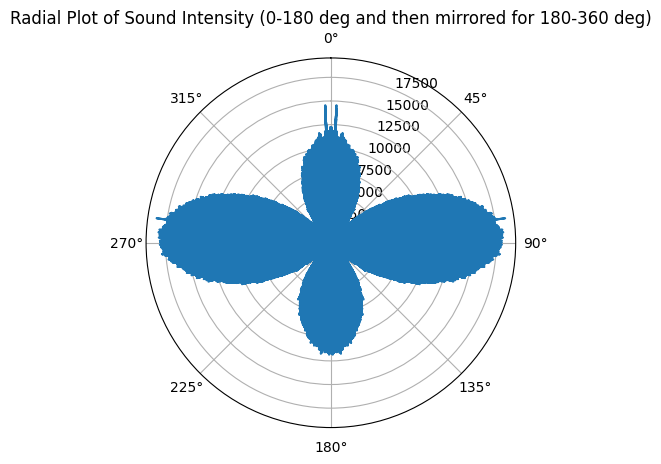

In [82]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles_full, abs(d1s_rotation_full))

ax.set_theta_direction(-1)  # To make clockwise rotation
ax.set_theta_zero_location("N")  # Set 0 degrees to the top
ax.set_title("Radial Plot of Sound Intensity (0-180 deg and then mirrored for 180-360 deg)")

plt.show()

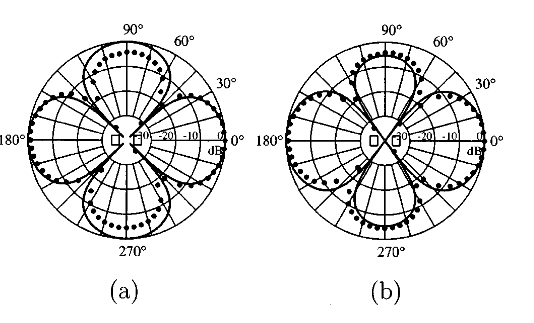

Compared to this image from the readings, I think my measurement and the data is reasonable.

## Filtering data from far field

I will now check on my very far field data and try some filtering and then follow a similar strategy to plot a radial plot.

I only plan to use the 30cm data as a backup i.e., if the 80cm data is completely useless.

In [114]:
fdata = np.take(data_80_sweep, 1, axis=1)
fdata = fdata - np.average(fdata) # to get rid of the dc offset

N = len(fdata) # sample points
T = 1 / samplerate_80_sweep

print(N, T)

yf = np.abs(fft(fdata)[0:N//2])
xf = fftfreq(N, T)[:N//2]

print(len(yf))

yf_f = np.zeros_like(yf)

print(len(yf_f))
yf_f[15000:30000] = yf[15000:30000]

print(yf_f[32000])

5760000 1.0416666666666666e-05
2880000
2880000
0.0


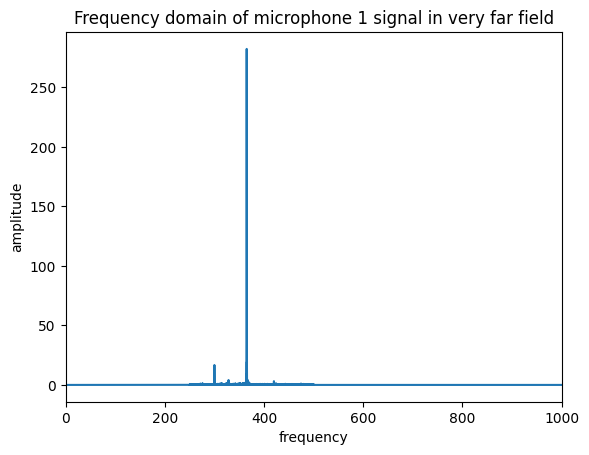

In [113]:
plt.plot(xf, 2.0/N * yf_f)
plt.title('Frequency domain of microphone 1 signal in very far field')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim([0,1000])
plt.show()

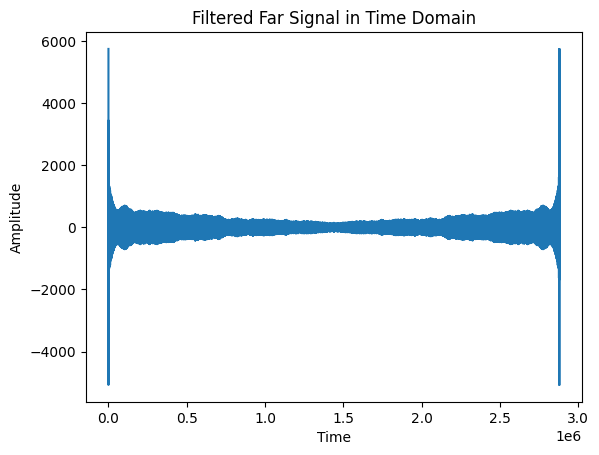

In [117]:
from scipy.fft import ifft

filtered_far_data = ifft(yf_f).real
plt.plot(filtered_far_data)
plt.title('Filtered Far Signal in Time Domain')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Hmmm i'm not sure this is what I'm looking to do...

In [120]:
N = len(filtered_far_data) # number of samples
angles = np.linspace(0, np.pi, N)

# reflect on x axis for full rotation
angles_full = np.concatenate((angles, angles + np.pi))
filtered_far_data_full = np.concatenate((filtered_far_data, filtered_far_data[::-1]))

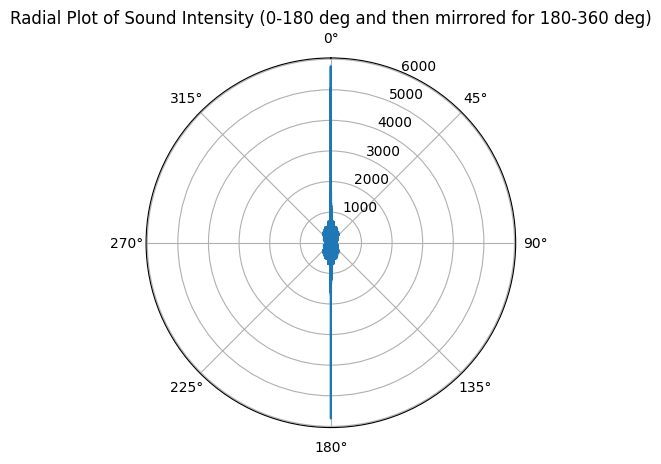

In [121]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles_full, abs(filtered_far_data_full))

ax.set_theta_direction(-1)  # To make clockwise rotation
ax.set_theta_zero_location("N")  # Set 0 degrees to the top
ax.set_title("Radial Plot of Sound Intensity (0-180 deg and then mirrored for 180-360 deg)")

plt.show()

Maybe I should have tried it without the filter first to check... yea, I guess I can do that now.

Wait a minute... I also didn't select the portion where the signal is actually being recorded while turning... okay a few things to do first before plotting, I think I jumped the gun.